In [35]:
import geopandas as gpd
import pandas as pd
from pathlib import Path
import warnings
# This warning is due to precision issues during union/intersection, data validated
warnings.filterwarnings("ignore", message="invalid value encountered in *", category=RuntimeWarning)

crs = 27700 # British National Grid, equal-area

pop = gpd.read_file('data/cambridge.geojson')
pop_column = 'Usual resident population'

iso_folder = Path('data/')
iso_glob = "route_*_isochrone.geojson"

# Create iso by merging files, making new column "route". This allows code to be modular and
# support any number of stations, routes and steps.
iso_list = []
for fp in iso_folder.glob(iso_glob):
    g = gpd.read_file(fp)
    g["route"] = fp.stem.split('_')[1]
    iso_list.append(g)
if not iso_list:
    raise RuntimeError("No isochrone files found. Check folder/pattern.")
iso = pd.concat(iso_list, ignore_index=True)


In [36]:
### Assertions of inputs ###
assert pop.is_valid.all(), "Some population geometries are invalid"
assert iso.is_valid.all(), "Some isochrone geometries are invalid"

assert "stepBoundaryMeters" in iso.columns, "Column 'stepBoundaryMeters' not found in iso"
assert pop_column in pop.columns, f"Column {pop_column} not found in pop"


In [37]:
### Cleaning ###

# Reproject CRS
pop = pop.to_crs(epsg=crs)
iso = iso.to_crs(epsg=crs)

# Add a stable ID for each isochrone row
iso = iso.reset_index(drop=True).copy()
iso["iso_id"] = iso.index  # unique ID per isochrone polygon

pop['population'] = pop[pop_column].astype('int64')
pop["pop_area"] = pop.geometry.area

# Reduce to only needed cols
pop = pop[['population', "pop_area", "geometry"]]
iso = iso[["iso_id", "route", "stepBoundaryMeters", "geometry"]]


<Axes: >

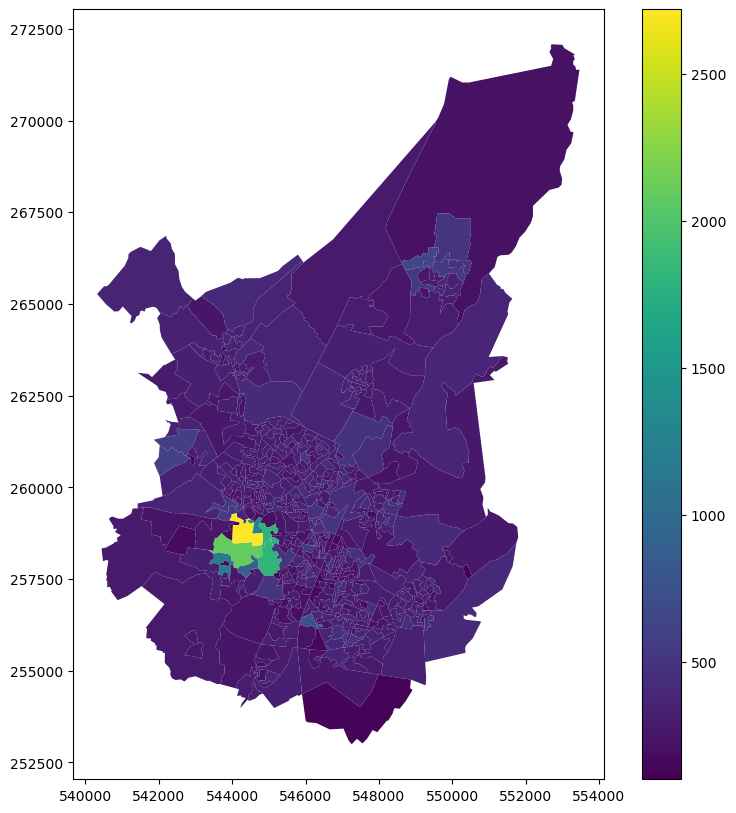

In [42]:
pop.plot(column='population', cmap='viridis', legend=True, figsize=(10,10))

## Subtask 2: Calculate population in each route/catchment

Approach: For each bus route and for each step catchment (e.g. 400m), make one polygon
that's the union of all station catchments, so that population calculation is only on
one polygon and also avoids double-counting in the process. Then, calculate population
by computing overlap with census tracts, calculating percent share, and merging back.

In [38]:
# Helper function to compute overlap between population dataset [p] and isochrone dataset [i],
# returning [inter], the non-empty pair-wise geometry intersections.
#
# Alex's note: This function allows the code to be easily reused to calculate other things,
# e.g. catchment for each station instead of union of all stations
def compute_overlap(p, i):
    # Intersections between census polygons and each isochrone.
    # Worst-case O(N x M) but GeoPandas uses spatial indexing, closer to linear.
    # Makes subtask 2 take 303ms for 5000-row iso df and 467-row pop df.
    inter = gpd.overlay(p, i, how="intersection", keep_geom_type=True)

    # Compute area overlap
    inter["inter_area"] = inter.geometry.area
    inter["pop_share"] = (inter["inter_area"] / inter["pop_area"]).clip(0, 1)
    inter["pop_weighted"] = inter['population'] * inter["pop_share"]
    return inter

def calculate_pops(p, i):
    # Dissolve by (route, stepBoundaryMeters) to merge all isochrones for a given route & band
    union_by_route_step = i.dissolve(by=["route", "stepBoundaryMeters"]).reset_index()
    union_by_route_step = union_by_route_step[["route", "stepBoundaryMeters", "geometry"]]

    # Compute overlap and merge back
    inter_route = compute_overlap(p, union_by_route_step)
    per_route_step = inter_route.groupby(["route", "stepBoundaryMeters"], as_index=False)["pop_weighted"].sum()

    # Rename, sort, round
    per_route_step = (
        per_route_step
        .rename(columns={"pop_weighted": "population"})
        .assign(population=lambda df: df["population"].round().astype("int64"))
        .sort_values(["route", "stepBoundaryMeters"])
        .set_index(["route", "stepBoundaryMeters"])
    )
    return per_route_step

per_route_step = calculate_pops(pop, iso)

# Save
per_route_step.to_csv('per_route_step.csv')
per_route_step.to_json('per_route_step.json')
per_route_step

population
route stepBoundaryMeters            
1     400                      10851
      800                      28192
2     400                      18311
      800                      46594

In [39]:
# Alex's note: If I had more time and wanted a robust script, I would write 5-10 test cases here
# with dummy data for regular and corner case handling on calculate_pops() function.

## Subtask 3: Calculate population within 400m
Approach: take only 800m results, calculate trips for daily and occasional riders. This was chosen because using both 5% and 3% would be double-counting residents.


In [40]:
ridership_assumptions = {400: 0.05, 800: 0.03}
frequent_trips_per_week = 14
occasional_trips_per_week = 2
occasional_riders_multipler = 2.66

riders = per_route_step.reset_index()
riders['daily_riders'] = riders.apply(lambda row: row['population'] * ridership_assumptions[row['stepBoundaryMeters']], axis=1)
riders['occasional_riders'] = riders['daily_riders'] * occasional_riders_multipler
riders['trips_per_week'] = riders['daily_riders'] * frequent_trips_per_week + riders['occasional_riders'] * occasional_trips_per_week
riders['trips_per_week'] = riders['trips_per_week'].round().astype('int64')

riders.to_csv('riders.csv')
riders


,route,stepBoundaryMeters,population,daily_riders,occasional_riders,trips_per_week
0,1,400,10851,542.55,1443.1830,10482
1,1,800,28192,845.76,2249.7216,16340
2,2,400,18311,915.55,2435.3630,17688
3,2,800,46594,1397.82,3718.2012,27006
